## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU，若有 GPU 且想開啟，可設為 "0"，不需使用 GPU, 將 GPU 設定為 ""
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
# 用 Keras 來構建一個分類神經網絡，用到的數據集是 MNIST，就是 0 到 9 這幾個數字的圖片數據集。
# 從 Keras 的內建功能中，取得 cifar10 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [3]:
# 資料前處理 - 標準化
# 因為每個像素都是在 0 到 255 之間的，標準化之後就變成了 0 到 1 之間。
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [11]:
# X 是一張張圖片，Y 是每張圖片對應的標籤，即它是哪個數字。
# 將 X 與 Y 獨立放進變數
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
# 資料前處理 - X 標準化，在上一個區塊已經定義了preproc_x的功能
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
# 資料前處理 -Y 轉成 onehot，在上一個區塊已經定義了preproc_y的功能
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [12]:
from keras.layers import BatchNormalization, Activation
from keras.layers import Dropout
from keras.regularizers import l1_l2

"""
建立神經網路
1. 加入 L1_L2
2. 加入 dropout
3. 加入 batch-normalization
"""

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], pre_activate=False, drp_ratio=0.2, l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
            
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
                
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [26]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 3
MOMENTUM = 0.95

"""
建立實驗組合
"""
Dropout_EXP = [0.1, 0.2]
LAYER_NEURONS = [[128, 128],[128, 256]]
BATCH_SIZE = [2, 16, 32]
PRE_ACTIVATE = [True, False]
L1_EXP = [1e-2, 1e-4, 0.0]
L2_EXP = [1e-2, 1e-4, 0.0]

In [27]:
from numpy import *
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
results = {}
for i, (l1r, l2r, layer_neurons, drp_rate, use_preact, bz) in enumerate(itertools.product(L1_EXP, L2_EXP, LAYER_NEURONS, Dropout_EXP, PRE_ACTIVATE, BATCH_SIZE)):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Numbers of exp: %i,L1 = %.6f, L2 = %.6f, layer: %s, dropout_rate: %.2f, use_preact: %s, batch_size: %i" % (i, l1r, l2r, layer_neurons, drp_rate, use_preact, bz))
    model = build_mlp(input_shape=x_train.shape[1:], pre_activate=use_preact, l1_ratio=l1r, l2_ratio=l2r, num_neurons=layer_neurons, drp_ratio=drp_rate)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS,
              batch_size=bz, 
              validation_data=(x_test, y_test),
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-accuracy': train_acc,
                             'valid-accuracy': valid_acc}

Numbers of exp: 0,L1 = 0.010000, L2 = 0.010000, layer: [128, 128], dropout_rate: 0.10, use_preact: True, batch_size: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               16512     
______

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 226s 5ms/step - loss: 7.7337 - accuracy: 0.1285 - val_loss: 7.9001 - val_accuracy: 0.1238
Epoch 2/3
50000/50000 [==============================] - 243s 5ms/step - loss: 3.3848 - accuracy: 0.1092 - val_loss: 2.3448 - val_accuracy: 0.1000
Epoch 3/3
50000/50000 [==============================] - 255s 5ms/step - loss: 2.3428 - accuracy: 0.1018 - val_loss: 2.3420 - val_accuracy: 0.1000
Numbers of exp: 4,L1 = 0.010000, L2 = 0.010000, layer: [128, 128], dropout_rate: 0.10, use_preact: False, batch_size: 16
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 29s 588us/step - loss: 8.1734 - accuracy: 0.2037 - val_loss: 4.6131 - val_accuracy: 0.1628
Epoch 2/3
50000/50000 [==============================] - 29s 580us/step - loss: 4.1827 - accuracy: 0.2214 - val_loss: 4.0922 - val_accuracy: 0.1725
Epoch 3/3
50000/50000 [==============================] - 29s 580us/step - loss: 4.0734 - accuracy: 0.2187 - val_loss: 4.2033 - val_accuracy: 0.2045
Numbers of exp: 8,L1 = 0.010000, L2 = 0.010000, layer: [128, 128], dropout_rate: 0.20, use_preact: True, batch_size: 32
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 16s 316us/step - loss: 11.1641 - accuracy: 0.1954 - val_loss: 3.3894 - val_accuracy: 0.1747
Epoch 2/3
50000/50000 [==============================] - 15s 308us/step - loss: 2.7889 - accuracy: 0.1889 - val_loss: 2.4380 - val_accuracy: 0.1656
Epoch 3/3
50000/50000 [==============================] - 15s 308us/step - loss: 2.4537 - accuracy: 0.1605 - val_loss: 2.5537 - val_accuracy: 0.1000
Numbers of exp: 12,L1 = 0.010000, L2 = 0.010000, layer: [128, 256], dropout_rate: 0.10, use_preact: True, batch_size: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 230s 5ms/step - loss: 7.1663 - accuracy: 0.1233 - val_loss: 3.5022 - val_accuracy: 0.1264
Epoch 2/3
50000/50000 [==============================] - 229s 5ms/step - loss: 4.5923 - accuracy: 0.1185 - val_loss: 4.0559 - val_accuracy: 0.1002
Epoch 3/3
50000/50000 [==============================] - 229s 5ms/step - loss: 2.8270 - accuracy: 0.1043 - val_loss: 2.3451 - val_accuracy: 0.1000
Numbers of exp: 16,L1 = 0.010000, L2 = 0.010000, layer: [128, 256], dropout_rate: 0.10, use_preact: False, batch_size: 16
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 31s 622us/step - loss: 8.8989 - accuracy: 0.2033 - val_loss: 4.9958 - val_accuracy: 0.1799
Epoch 2/3
50000/50000 [==============================] - 32s 636us/step - loss: 4.3494 - accuracy: 0.2167 - val_loss: 4.5609 - val_accuracy: 0.1515
Epoch 3/3
50000/50000 [==============================] - 32s 643us/step - loss: 4.1979 - accuracy: 0.2196 - val_loss: 4.4322 - val_accuracy: 0.1843
Numbers of exp: 20,L1 = 0.010000, L2 = 0.010000, layer: [128, 256], dropout_rate: 0.20, use_preact: True, batch_size: 32
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 16s 324us/step - loss: 11.9349 - accuracy: 0.1976 - val_loss: 3.8720 - val_accuracy: 0.1334
Epoch 2/3
50000/50000 [==============================] - 16s 315us/step - loss: 2.7820 - accuracy: 0.1973 - val_loss: 2.8271 - val_accuracy: 0.1516
Epoch 3/3
50000/50000 [==============================] - 16s 317us/step - loss: 2.4498 - accuracy: 0.1881 - val_loss: 2.3557 - val_accuracy: 0.1802
Numbers of exp: 24,L1 = 0.010000, L2 = 0.000100, layer: [128, 128], dropout_rate: 0.10, use_preact: True, batch_size: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 234s 5ms/step - loss: 7.7735 - accuracy: 0.1249 - val_loss: 5.3946 - val_accuracy: 0.1161
Epoch 2/3
50000/50000 [==============================] - 225s 5ms/step - loss: 4.7023 - accuracy: 0.1192 - val_loss: 4.2626 - val_accuracy: 0.1056
Epoch 3/3
50000/50000 [==============================] - 226s 5ms/step - loss: 2.8039 - accuracy: 0.1075 - val_loss: 2.3424 - val_accuracy: 0.1000
Numbers of exp: 28,L1 = 0.010000, L2 = 0.000100, layer: [128, 128], dropout_rate: 0.10, use_preact: False, batch_size: 16
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 29s 580us/step - loss: 8.3229 - accuracy: 0.2031 - val_loss: 4.3851 - val_accuracy: 0.2140
Epoch 2/3
50000/50000 [==============================] - 29s 571us/step - loss: 4.2082 - accuracy: 0.2198 - val_loss: 4.3735 - val_accuracy: 0.1386
Epoch 3/3
50000/50000 [==============================] - 28s 567us/step - loss: 4.0805 - accuracy: 0.2186 - val_loss: 4.0836 - val_accuracy: 0.1992
Numbers of exp: 32,L1 = 0.010000, L2 = 0.000100, layer: [128, 128], dropout_rate: 0.20, use_preact: True, batch_size: 32
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 16s 313us/step - loss: 11.4837 - accuracy: 0.1920 - val_loss: 3.0096 - val_accuracy: 0.1890
Epoch 2/3
50000/50000 [==============================] - 15s 306us/step - loss: 2.6880 - accuracy: 0.1922 - val_loss: 2.8268 - val_accuracy: 0.1000
Epoch 3/3
50000/50000 [==============================] - 15s 304us/step - loss: 2.5973 - accuracy: 0.1700 - val_loss: 3.0669 - val_accuracy: 0.1442
Numbers of exp: 36,L1 = 0.010000, L2 = 0.000100, layer: [128, 256], dropout_rate: 0.10, use_preact: True, batch_size: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 223s 4ms/step - loss: 8.2340 - accuracy: 0.1265 - val_loss: 4.4582 - val_accuracy: 0.1013
Epoch 2/3
50000/50000 [==============================] - 227s 5ms/step - loss: 4.7011 - accuracy: 0.1290 - val_loss: 5.5442 - val_accuracy: 0.1401
Epoch 3/3
50000/50000 [==============================] - 231s 5ms/step - loss: 4.8691 - accuracy: 0.1229 - val_loss: 2.8332 - val_accuracy: 0.0995
Numbers of exp: 40,L1 = 0.010000, L2 = 0.000100, layer: [128, 256], dropout_rate: 0.10, use_preact: False, batch_size: 16
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 31s 625us/step - loss: 8.9891 - accuracy: 0.2035 - val_loss: 4.6376 - val_accuracy: 0.1267
Epoch 2/3
50000/50000 [==============================] - 31s 614us/step - loss: 4.3464 - accuracy: 0.2185 - val_loss: 5.3110 - val_accuracy: 0.1000
Epoch 3/3
50000/50000 [==============================] - 31s 613us/step - loss: 4.2199 - accuracy: 0.2211 - val_loss: 4.1803 - val_accuracy: 0.1736
Numbers of exp: 44,L1 = 0.010000, L2 = 0.000100, layer: [128, 256], dropout_rate: 0.20, use_preact: True, batch_size: 32
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 16s 321us/step - loss: 12.2688 - accuracy: 0.1961 - val_loss: 3.4060 - val_accuracy: 0.1323
Epoch 2/3
50000/50000 [==============================] - 16s 312us/step - loss: 2.8002 - accuracy: 0.1941 - val_loss: 3.0302 - val_accuracy: 0.1091
Epoch 3/3
50000/50000 [==============================] - 16s 314us/step - loss: 2.5011 - accuracy: 0.1893 - val_loss: 2.6184 - val_accuracy: 0.1463
Numbers of exp: 48,L1 = 0.010000, L2 = 0.000000, layer: [128, 128], dropout_rate: 0.10, use_preact: True, batch_size: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 174s 3ms/step - loss: 8.2411 - accuracy: 0.1248 - val_loss: 4.6782 - val_accuracy: 0.1498
Epoch 2/3
50000/50000 [==============================] - 175s 3ms/step - loss: 5.2399 - accuracy: 0.1222 - val_loss: 9.0346 - val_accuracy: 0.1230
Epoch 3/3
50000/50000 [==============================] - 174s 3ms/step - loss: 4.2957 - accuracy: 0.1097 - val_loss: 2.3424 - val_accuracy: 0.1000
Numbers of exp: 52,L1 = 0.010000, L2 = 0.000000, layer: [128, 128], dropout_rate: 0.10, use_preact: False, batch_size: 16
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 24s 477us/step - loss: 8.3053 - accuracy: 0.2032 - val_loss: 4.4367 - val_accuracy: 0.1911
Epoch 2/3
50000/50000 [==============================] - 23s 466us/step - loss: 4.1749 - accuracy: 0.2195 - val_loss: 4.6017 - val_accuracy: 0.1102
Epoch 3/3
50000/50000 [==============================] - 23s 469us/step - loss: 4.0546 - accuracy: 0.2233 - val_loss: 4.2101 - val_accuracy: 0.1935
Numbers of exp: 56,L1 = 0.010000, L2 = 0.000000, layer: [128, 128], dropout_rate: 0.20, use_preact: True, batch_size: 32
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 13s 261us/step - loss: 11.4307 - accuracy: 0.1949 - val_loss: 2.9874 - val_accuracy: 0.2141
Epoch 2/3
50000/50000 [==============================] - 13s 255us/step - loss: 2.7790 - accuracy: 0.1969 - val_loss: 2.7514 - val_accuracy: 0.1570
Epoch 3/3
50000/50000 [==============================] - 13s 254us/step - loss: 2.5256 - accuracy: 0.1806 - val_loss: 2.3855 - val_accuracy: 0.1628
Numbers of exp: 60,L1 = 0.010000, L2 = 0.000000, layer: [128, 256], dropout_rate: 0.10, use_preact: True, batch_size: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 182s 4ms/step - loss: 7.3269 - accuracy: 0.1253 - val_loss: 4.1705 - val_accuracy: 0.1008
Epoch 2/3
50000/50000 [==============================] - 185s 4ms/step - loss: 4.5948 - accuracy: 0.1228 - val_loss: 3.6092 - val_accuracy: 0.1114
Epoch 3/3
50000/50000 [==============================] - 178s 4ms/step - loss: 4.4707 - accuracy: 0.1179 - val_loss: 2.3460 - val_accuracy: 0.1000
Numbers of exp: 64,L1 = 0.010000, L2 = 0.000000, layer: [128, 256], dropout_rate: 0.10, use_preact: False, batch_size: 16
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 24s 488us/step - loss: 9.0209 - accuracy: 0.2022 - val_loss: 4.4331 - val_accuracy: 0.1866
Epoch 2/3
50000/50000 [==============================] - 24s 487us/step - loss: 4.2971 - accuracy: 0.2184 - val_loss: 4.2695 - val_accuracy: 0.2125
Epoch 3/3
50000/50000 [==============================] - 24s 479us/step - loss: 4.2173 - accuracy: 0.2173 - val_loss: 4.4684 - val_accuracy: 0.1317
Numbers of exp: 68,L1 = 0.010000, L2 = 0.000000, layer: [128, 256], dropout_rate: 0.20, use_preact: True, batch_size: 32
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 14s 283us/step - loss: 12.1548 - accuracy: 0.1956 - val_loss: 3.3125 - val_accuracy: 0.1419
Epoch 2/3
50000/50000 [==============================] - 14s 274us/step - loss: 2.7035 - accuracy: 0.1901 - val_loss: 2.8516 - val_accuracy: 0.1375
Epoch 3/3
50000/50000 [==============================] - 14s 278us/step - loss: 2.5118 - accuracy: 0.1737 - val_loss: 2.4660 - val_accuracy: 0.1000
Numbers of exp: 72,L1 = 0.000100, L2 = 0.010000, layer: [128, 128], dropout_rate: 0.10, use_preact: True, batch_size: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 221s 4ms/step - loss: 3.5764 - accuracy: 0.1411 - val_loss: 2.5524 - val_accuracy: 0.1923
Epoch 2/3
50000/50000 [==============================] - 220s 4ms/step - loss: 2.6229 - accuracy: 0.1460 - val_loss: 2.5006 - val_accuracy: 0.1680
Epoch 3/3
50000/50000 [==============================] - 221s 4ms/step - loss: 2.5578 - accuracy: 0.1421 - val_loss: 2.4461 - val_accuracy: 0.1772
Numbers of exp: 76,L1 = 0.000100, L2 = 0.010000, layer: [128, 128], dropout_rate: 0.10, use_preact: False, batch_size: 16
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 30s 604us/step - loss: 3.7018 - accuracy: 0.3134 - val_loss: 2.4076 - val_accuracy: 0.3216
Epoch 2/3
50000/50000 [==============================] - 30s 595us/step - loss: 2.1151 - accuracy: 0.3530 - val_loss: 2.2485 - val_accuracy: 0.2976
Epoch 3/3
50000/50000 [==============================] - 30s 596us/step - loss: 2.0521 - accuracy: 0.3532 - val_loss: 2.1005 - val_accuracy: 0.3319
Numbers of exp: 80,L1 = 0.000100, L2 = 0.010000, layer: [128, 128], dropout_rate: 0.20, use_preact: True, batch_size: 32
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 16s 314us/step - loss: 4.8072 - accuracy: 0.2671 - val_loss: 3.3522 - val_accuracy: 0.2832
Epoch 2/3
50000/50000 [==============================] - 15s 303us/step - loss: 2.7458 - accuracy: 0.2887 - val_loss: 2.4285 - val_accuracy: 0.2571
Epoch 3/3
50000/50000 [==============================] - 15s 303us/step - loss: 2.1816 - accuracy: 0.2851 - val_loss: 1.9933 - val_accuracy: 0.3319
Numbers of exp: 84,L1 = 0.000100, L2 = 0.010000, layer: [128, 256], dropout_rate: 0.10, use_preact: True, batch_size: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 223s 4ms/step - loss: 3.9087 - accuracy: 0.1390 - val_loss: 2.3886 - val_accuracy: 0.1697
Epoch 2/3
50000/50000 [==============================] - 223s 4ms/step - loss: 2.4347 - accuracy: 0.1367 - val_loss: 2.4135 - val_accuracy: 0.1461
Epoch 3/3
50000/50000 [==============================] - 223s 4ms/step - loss: 2.4604 - accuracy: 0.1342 - val_loss: 2.5916 - val_accuracy: 0.1201
Numbers of exp: 88,L1 = 0.000100, L2 = 0.010000, layer: [128, 256], dropout_rate: 0.10, use_preact: False, batch_size: 16
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 31s 623us/step - loss: 3.9175 - accuracy: 0.3112 - val_loss: 2.3691 - val_accuracy: 0.3329
Epoch 2/3
50000/50000 [==============================] - 30s 609us/step - loss: 2.1579 - accuracy: 0.3525 - val_loss: 2.1724 - val_accuracy: 0.3296
Epoch 3/3
50000/50000 [==============================] - 30s 602us/step - loss: 2.0741 - accuracy: 0.3529 - val_loss: 1.9927 - val_accuracy: 0.3894
Numbers of exp: 92,L1 = 0.000100, L2 = 0.010000, layer: [128, 256], dropout_rate: 0.20, use_preact: True, batch_size: 32
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 16s 328us/step - loss: 5.1239 - accuracy: 0.2684 - val_loss: 3.5082 - val_accuracy: 0.2843
Epoch 2/3
50000/50000 [==============================] - 16s 313us/step - loss: 2.8105 - accuracy: 0.2992 - val_loss: 2.5368 - val_accuracy: 0.2459
Epoch 3/3
50000/50000 [==============================] - 16s 314us/step - loss: 2.1588 - accuracy: 0.3051 - val_loss: 2.0866 - val_accuracy: 0.2812
Numbers of exp: 96,L1 = 0.000100, L2 = 0.000100, layer: [128, 128], dropout_rate: 0.10, use_preact: True, batch_size: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 230s 5ms/step - loss: 3.6405 - accuracy: 0.1574 - val_loss: 3.1628 - val_accuracy: 0.2010
Epoch 2/3
50000/50000 [==============================] - 225s 5ms/step - loss: 2.9680 - accuracy: 0.1670 - val_loss: 2.9308 - val_accuracy: 0.2302
Epoch 3/3
50000/50000 [==============================] - 225s 4ms/step - loss: 2.7964 - accuracy: 0.1630 - val_loss: 2.7815 - val_accuracy: 0.2133
Numbers of exp: 100,L1 = 0.000100, L2 = 0.000100, layer: [128, 128], dropout_rate: 0.10, use_preact: False, batch_size: 16
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 30s 610us/step - loss: 2.8033 - accuracy: 0.3154 - val_loss: 2.5064 - val_accuracy: 0.3810
Epoch 2/3
50000/50000 [==============================] - 30s 594us/step - loss: 2.4261 - accuracy: 0.3816 - val_loss: 2.2539 - val_accuracy: 0.4061
Epoch 3/3
50000/50000 [==============================] - 30s 590us/step - loss: 2.2144 - accuracy: 0.3970 - val_loss: 2.0795 - val_accuracy: 0.4168
Numbers of exp: 104,L1 = 0.000100, L2 = 0.000100, layer: [128, 128], dropout_rate: 0.20, use_preact: True, batch_size: 32
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_____________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 16s 314us/step - loss: 3.0055 - accuracy: 0.2729 - val_loss: 2.7124 - val_accuracy: 0.3422
Epoch 2/3
50000/50000 [==============================] - 16s 317us/step - loss: 2.7388 - accuracy: 0.3136 - val_loss: 2.7254 - val_accuracy: 0.3010
Epoch 3/3
50000/50000 [==============================] - 15s 308us/step - loss: 2.6202 - accuracy: 0.3130 - val_loss: 2.5344 - val_accuracy: 0.3477
Numbers of exp: 108,L1 = 0.000100, L2 = 0.000100, layer: [128, 256], dropout_rate: 0.10, use_preact: True, batch_size: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 225s 5ms/step - loss: 3.8804 - accuracy: 0.1523 - val_loss: 3.3629 - val_accuracy: 0.2091
Epoch 2/3
50000/50000 [==============================] - 233s 5ms/step - loss: 3.0967 - accuracy: 0.1687 - val_loss: 3.1298 - val_accuracy: 0.2420
Epoch 3/3
50000/50000 [==============================] - 228s 5ms/step - loss: 2.8004 - accuracy: 0.1636 - val_loss: 2.6684 - val_accuracy: 0.2315
Numbers of exp: 112,L1 = 0.000100, L2 = 0.000100, layer: [128, 256], dropout_rate: 0.10, use_preact: False, batch_size: 16
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 30s 593us/step - loss: 2.8690 - accuracy: 0.3223 - val_loss: 2.5355 - val_accuracy: 0.4085
Epoch 2/3
50000/50000 [==============================] - 30s 591us/step - loss: 2.4807 - accuracy: 0.3882 - val_loss: 2.2737 - val_accuracy: 0.4255
Epoch 3/3
50000/50000 [==============================] - 29s 583us/step - loss: 2.2674 - accuracy: 0.4051 - val_loss: 2.1242 - val_accuracy: 0.4291
Numbers of exp: 116,L1 = 0.000100, L2 = 0.000100, layer: [128, 256], dropout_rate: 0.20, use_preact: True, batch_size: 32
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_____________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 16s 323us/step - loss: 3.1099 - accuracy: 0.2660 - val_loss: 2.9120 - val_accuracy: 0.2947
Epoch 2/3
50000/50000 [==============================] - 16s 315us/step - loss: 2.8127 - accuracy: 0.3148 - val_loss: 2.6358 - val_accuracy: 0.3623
Epoch 3/3
50000/50000 [==============================] - 16s 314us/step - loss: 2.6519 - accuracy: 0.3258 - val_loss: 2.5254 - val_accuracy: 0.3611
Numbers of exp: 120,L1 = 0.000100, L2 = 0.000000, layer: [128, 128], dropout_rate: 0.10, use_preact: True, batch_size: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 175s 4ms/step - loss: 3.6180 - accuracy: 0.1536 - val_loss: 3.3747 - val_accuracy: 0.2296
Epoch 2/3
50000/50000 [==============================] - 174s 3ms/step - loss: 3.0233 - accuracy: 0.1681 - val_loss: 2.9126 - val_accuracy: 0.2301
Epoch 3/3
50000/50000 [==============================] - 174s 3ms/step - loss: 2.8205 - accuracy: 0.1680 - val_loss: 2.8832 - val_accuracy: 0.2529
Numbers of exp: 124,L1 = 0.000100, L2 = 0.000000, layer: [128, 128], dropout_rate: 0.10, use_preact: False, batch_size: 16
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 24s 479us/step - loss: 2.7720 - accuracy: 0.3182 - val_loss: 2.4566 - val_accuracy: 0.3926
Epoch 2/3
50000/50000 [==============================] - 23s 468us/step - loss: 2.4189 - accuracy: 0.3800 - val_loss: 2.2176 - val_accuracy: 0.4187
Epoch 3/3
50000/50000 [==============================] - 23s 468us/step - loss: 2.2186 - accuracy: 0.3999 - val_loss: 2.0950 - val_accuracy: 0.4180
Numbers of exp: 128,L1 = 0.000100, L2 = 0.000000, layer: [128, 128], dropout_rate: 0.20, use_preact: True, batch_size: 32
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_____________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 13s 260us/step - loss: 2.9689 - accuracy: 0.2749 - val_loss: 2.7288 - val_accuracy: 0.3310
Epoch 2/3
50000/50000 [==============================] - 13s 254us/step - loss: 2.7272 - accuracy: 0.3072 - val_loss: 2.5452 - val_accuracy: 0.3666
Epoch 3/3
50000/50000 [==============================] - 13s 251us/step - loss: 2.5887 - accuracy: 0.3196 - val_loss: 2.5359 - val_accuracy: 0.3054
Numbers of exp: 132,L1 = 0.000100, L2 = 0.000000, layer: [128, 256], dropout_rate: 0.10, use_preact: True, batch_size: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 189s 4ms/step - loss: 3.7443 - accuracy: 0.1454 - val_loss: 5.4521 - val_accuracy: 0.2268
Epoch 2/3
50000/50000 [==============================] - 184s 4ms/step - loss: 3.0777 - accuracy: 0.1681 - val_loss: 3.7535 - val_accuracy: 0.2551
Epoch 3/3
50000/50000 [==============================] - 181s 4ms/step - loss: 2.8485 - accuracy: 0.1668 - val_loss: 2.8652 - val_accuracy: 0.2579
Numbers of exp: 136,L1 = 0.000100, L2 = 0.000000, layer: [128, 256], dropout_rate: 0.10, use_preact: False, batch_size: 16
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 25s 493us/step - loss: 2.8434 - accuracy: 0.3189 - val_loss: 2.5763 - val_accuracy: 0.3764
Epoch 2/3
50000/50000 [==============================] - 24s 480us/step - loss: 2.4784 - accuracy: 0.3828 - val_loss: 2.2800 - val_accuracy: 0.4228
Epoch 3/3
50000/50000 [==============================] - 24s 483us/step - loss: 2.2774 - accuracy: 0.4000 - val_loss: 2.2041 - val_accuracy: 0.3887
Numbers of exp: 140,L1 = 0.000100, L2 = 0.000000, layer: [128, 256], dropout_rate: 0.20, use_preact: True, batch_size: 32
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_____________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 14s 285us/step - loss: 3.0677 - accuracy: 0.2684 - val_loss: 2.7441 - val_accuracy: 0.3576
Epoch 2/3
50000/50000 [==============================] - 14s 274us/step - loss: 2.7802 - accuracy: 0.3185 - val_loss: 2.6292 - val_accuracy: 0.3550
Epoch 3/3
50000/50000 [==============================] - 14s 270us/step - loss: 2.6579 - accuracy: 0.3261 - val_loss: 2.4753 - val_accuracy: 0.3830
Numbers of exp: 144,L1 = 0.000000, L2 = 0.010000, layer: [128, 128], dropout_rate: 0.10, use_preact: True, batch_size: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 171s 3ms/step - loss: 3.5459 - accuracy: 0.1436 - val_loss: 2.3948 - val_accuracy: 0.1633
Epoch 2/3
50000/50000 [==============================] - 171s 3ms/step - loss: 2.6560 - accuracy: 0.1301 - val_loss: 2.3863 - val_accuracy: 0.1582
Epoch 3/3
50000/50000 [==============================] - 171s 3ms/step - loss: 2.9351 - accuracy: 0.1232 - val_loss: 2.6390 - val_accuracy: 0.1262
Numbers of exp: 148,L1 = 0.000000, L2 = 0.010000, layer: [128, 128], dropout_rate: 0.10, use_preact: False, batch_size: 16
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 24s 488us/step - loss: 3.3621 - accuracy: 0.3171 - val_loss: 2.3530 - val_accuracy: 0.3058
Epoch 2/3
50000/50000 [==============================] - 24s 473us/step - loss: 2.0304 - accuracy: 0.3624 - val_loss: 1.9273 - val_accuracy: 0.3765
Epoch 3/3
50000/50000 [==============================] - 24s 480us/step - loss: 1.9230 - accuracy: 0.3714 - val_loss: 1.9688 - val_accuracy: 0.3451
Numbers of exp: 152,L1 = 0.000000, L2 = 0.010000, layer: [128, 128], dropout_rate: 0.20, use_preact: True, batch_size: 32
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_____________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 13s 256us/step - loss: 4.2697 - accuracy: 0.2722 - val_loss: 3.0864 - val_accuracy: 0.2919
Epoch 2/3
50000/50000 [==============================] - 12s 249us/step - loss: 2.6008 - accuracy: 0.3062 - val_loss: 2.2025 - val_accuracy: 0.3424
Epoch 3/3
50000/50000 [==============================] - 12s 249us/step - loss: 2.1850 - accuracy: 0.2865 - val_loss: 2.0377 - val_accuracy: 0.2991
Numbers of exp: 156,L1 = 0.000000, L2 = 0.010000, layer: [128, 256], dropout_rate: 0.10, use_preact: True, batch_size: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 176s 4ms/step - loss: 3.6557 - accuracy: 0.1336 - val_loss: 2.3139 - val_accuracy: 0.1379
Epoch 2/3
50000/50000 [==============================] - 176s 4ms/step - loss: 2.3976 - accuracy: 0.1353 - val_loss: 2.5835 - val_accuracy: 0.1591
Epoch 3/3
50000/50000 [==============================] - 184s 4ms/step - loss: 2.5028 - accuracy: 0.1339 - val_loss: 2.4080 - val_accuracy: 0.1778
Numbers of exp: 160,L1 = 0.000000, L2 = 0.010000, layer: [128, 256], dropout_rate: 0.10, use_preact: False, batch_size: 16
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 24s 487us/step - loss: 3.5451 - accuracy: 0.3164 - val_loss: 2.3427 - val_accuracy: 0.3339
Epoch 2/3
50000/50000 [==============================] - 24s 473us/step - loss: 2.0621 - accuracy: 0.3645 - val_loss: 1.8863 - val_accuracy: 0.3969
Epoch 3/3
50000/50000 [==============================] - 24s 473us/step - loss: 1.9364 - accuracy: 0.3751 - val_loss: 1.9705 - val_accuracy: 0.3584
Numbers of exp: 164,L1 = 0.000000, L2 = 0.010000, layer: [128, 256], dropout_rate: 0.20, use_preact: True, batch_size: 32
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_____________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 13s 270us/step - loss: 4.5534 - accuracy: 0.2659 - val_loss: 3.4010 - val_accuracy: 0.2487
Epoch 2/3
50000/50000 [==============================] - 13s 260us/step - loss: 2.6946 - accuracy: 0.2951 - val_loss: 2.2930 - val_accuracy: 0.3224
Epoch 3/3
50000/50000 [==============================] - 13s 264us/step - loss: 2.1935 - accuracy: 0.2865 - val_loss: 2.0274 - val_accuracy: 0.3008
Numbers of exp: 168,L1 = 0.000000, L2 = 0.000100, layer: [128, 128], dropout_rate: 0.10, use_preact: True, batch_size: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 171s 3ms/step - loss: 2.4552 - accuracy: 0.1572 - val_loss: 3.0986 - val_accuracy: 0.2247
Epoch 2/3
50000/50000 [==============================] - 170s 3ms/step - loss: 2.4137 - accuracy: 0.1717 - val_loss: 3.2389 - val_accuracy: 0.2477
Epoch 3/3
50000/50000 [==============================] - 171s 3ms/step - loss: 2.4127 - accuracy: 0.1762 - val_loss: 5.0116 - val_accuracy: 0.2267
Numbers of exp: 172,L1 = 0.000000, L2 = 0.000100, layer: [128, 128], dropout_rate: 0.10, use_preact: False, batch_size: 16
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 23s 460us/step - loss: 1.9223 - accuracy: 0.3217 - val_loss: 1.7708 - val_accuracy: 0.3806
Epoch 2/3
50000/50000 [==============================] - 23s 453us/step - loss: 1.7622 - accuracy: 0.3829 - val_loss: 1.6655 - val_accuracy: 0.4215
Epoch 3/3
50000/50000 [==============================] - 23s 455us/step - loss: 1.7049 - accuracy: 0.4069 - val_loss: 1.5981 - val_accuracy: 0.4429
Numbers of exp: 176,L1 = 0.000000, L2 = 0.000100, layer: [128, 128], dropout_rate: 0.20, use_preact: True, batch_size: 32
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_____________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 13s 257us/step - loss: 2.0752 - accuracy: 0.2739 - val_loss: 1.8989 - val_accuracy: 0.3197
Epoch 2/3
50000/50000 [==============================] - 13s 251us/step - loss: 1.9014 - accuracy: 0.3285 - val_loss: 1.7645 - val_accuracy: 0.3801
Epoch 3/3
50000/50000 [==============================] - 12s 250us/step - loss: 1.8854 - accuracy: 0.3319 - val_loss: 1.8048 - val_accuracy: 0.3526
Numbers of exp: 180,L1 = 0.000000, L2 = 0.000100, layer: [128, 256], dropout_rate: 0.10, use_preact: True, batch_size: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 174s 3ms/step - loss: 2.5573 - accuracy: 0.1486 - val_loss: 5.2446 - val_accuracy: 0.2160
Epoch 2/3
50000/50000 [==============================] - 173s 3ms/step - loss: 2.4563 - accuracy: 0.1699 - val_loss: 4.4622 - val_accuracy: 0.2443
Epoch 3/3
50000/50000 [==============================] - 173s 3ms/step - loss: 2.4475 - accuracy: 0.1684 - val_loss: 3.7869 - val_accuracy: 0.2376
Numbers of exp: 184,L1 = 0.000000, L2 = 0.000100, layer: [128, 256], dropout_rate: 0.10, use_preact: False, batch_size: 16
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 24s 484us/step - loss: 1.9294 - accuracy: 0.3253 - val_loss: 1.7124 - val_accuracy: 0.4140
Epoch 2/3
50000/50000 [==============================] - 23s 468us/step - loss: 1.7579 - accuracy: 0.3887 - val_loss: 1.6470 - val_accuracy: 0.4243
Epoch 3/3
50000/50000 [==============================] - 24s 478us/step - loss: 1.6957 - accuracy: 0.4118 - val_loss: 1.5803 - val_accuracy: 0.4553
Numbers of exp: 188,L1 = 0.000000, L2 = 0.000100, layer: [128, 256], dropout_rate: 0.20, use_preact: True, batch_size: 32
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_____________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 13s 269us/step - loss: 2.0787 - accuracy: 0.2791 - val_loss: 1.8364 - val_accuracy: 0.3356
Epoch 2/3
50000/50000 [==============================] - 13s 258us/step - loss: 1.9050 - accuracy: 0.3270 - val_loss: 1.8242 - val_accuracy: 0.3621
Epoch 3/3
50000/50000 [==============================] - 13s 256us/step - loss: 1.8667 - accuracy: 0.3407 - val_loss: 1.8453 - val_accuracy: 0.3437
Numbers of exp: 192,L1 = 0.000000, L2 = 0.000000, layer: [128, 128], dropout_rate: 0.10, use_preact: True, batch_size: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 132s 3ms/step - loss: 2.2774 - accuracy: 0.1589 - val_loss: 2.2688 - val_accuracy: 0.2307
Epoch 2/3
50000/50000 [==============================] - 137s 3ms/step - loss: 2.2303 - accuracy: 0.1694 - val_loss: 2.3234 - val_accuracy: 0.2454
Epoch 3/3
50000/50000 [==============================] - 132s 3ms/step - loss: 2.2228 - accuracy: 0.1718 - val_loss: 2.4603 - val_accuracy: 0.2384
Numbers of exp: 196,L1 = 0.000000, L2 = 0.000000, layer: [128, 128], dropout_rate: 0.10, use_preact: False, batch_size: 16
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 18s 369us/step - loss: 1.8911 - accuracy: 0.3200 - val_loss: 1.6728 - val_accuracy: 0.4075
Epoch 2/3
50000/50000 [==============================] - 19s 376us/step - loss: 1.7251 - accuracy: 0.3830 - val_loss: 1.5919 - val_accuracy: 0.4348
Epoch 3/3
50000/50000 [==============================] - 18s 359us/step - loss: 1.6627 - accuracy: 0.4060 - val_loss: 1.5626 - val_accuracy: 0.4467
Numbers of exp: 200,L1 = 0.000000, L2 = 0.000000, layer: [128, 128], dropout_rate: 0.20, use_preact: True, batch_size: 32
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_____________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 11s 213us/step - loss: 2.0626 - accuracy: 0.2598 - val_loss: 1.8606 - val_accuracy: 0.3341
Epoch 2/3
50000/50000 [==============================] - 10s 204us/step - loss: 1.8943 - accuracy: 0.3148 - val_loss: 1.8450 - val_accuracy: 0.3370
Epoch 3/3
50000/50000 [==============================] - 10s 206us/step - loss: 1.8967 - accuracy: 0.3125 - val_loss: 1.7543 - val_accuracy: 0.3795
Numbers of exp: 204,L1 = 0.000000, L2 = 0.000000, layer: [128, 256], dropout_rate: 0.10, use_preact: True, batch_size: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 141s 3ms/step - loss: 2.3333 - accuracy: 0.1489 - val_loss: 3.4567 - val_accuracy: 0.2028
Epoch 2/3
50000/50000 [==============================] - 135s 3ms/step - loss: 2.2391 - accuracy: 0.1631 - val_loss: 4.0420 - val_accuracy: 0.2270
Epoch 3/3
50000/50000 [==============================] - 135s 3ms/step - loss: 2.2348 - accuracy: 0.1659 - val_loss: 3.5699 - val_accuracy: 0.2472
Numbers of exp: 208,L1 = 0.000000, L2 = 0.000000, layer: [128, 256], dropout_rate: 0.10, use_preact: False, batch_size: 16
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 19s 383us/step - loss: 1.8873 - accuracy: 0.3225 - val_loss: 1.6563 - val_accuracy: 0.4125
Epoch 2/3
50000/50000 [==============================] - 19s 374us/step - loss: 1.7202 - accuracy: 0.3854 - val_loss: 1.6077 - val_accuracy: 0.4329
Epoch 3/3
50000/50000 [==============================] - 19s 373us/step - loss: 1.6549 - accuracy: 0.4112 - val_loss: 1.5390 - val_accuracy: 0.4506
Numbers of exp: 212,L1 = 0.000000, L2 = 0.000000, layer: [128, 256], dropout_rate: 0.20, use_preact: True, batch_size: 32
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_____________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 11s 224us/step - loss: 2.0571 - accuracy: 0.2687 - val_loss: 1.8388 - val_accuracy: 0.3244
Epoch 2/3
50000/50000 [==============================] - 11s 217us/step - loss: 1.8781 - accuracy: 0.3186 - val_loss: 1.7147 - val_accuracy: 0.3858
Epoch 3/3
50000/50000 [==============================] - 11s 214us/step - loss: 1.8615 - accuracy: 0.3283 - val_loss: 1.7677 - val_accuracy: 0.3721


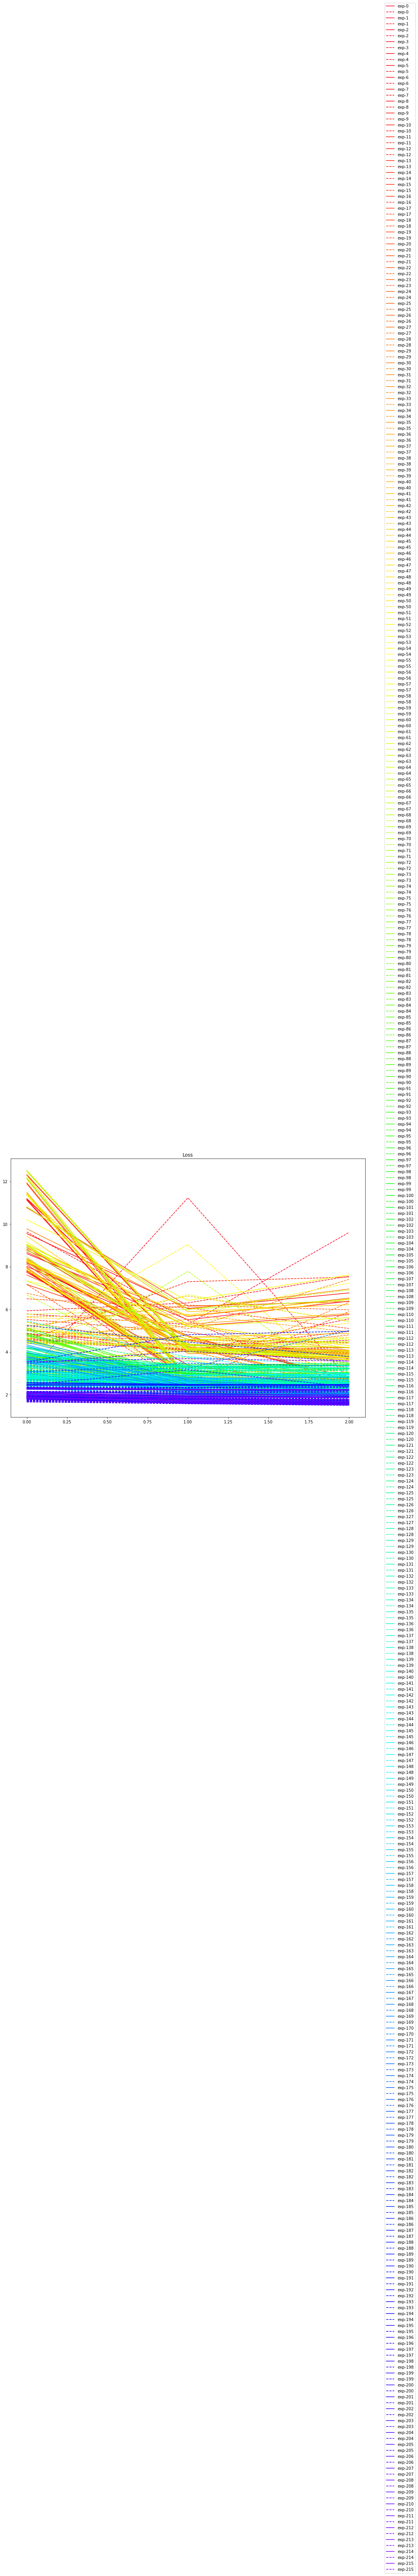

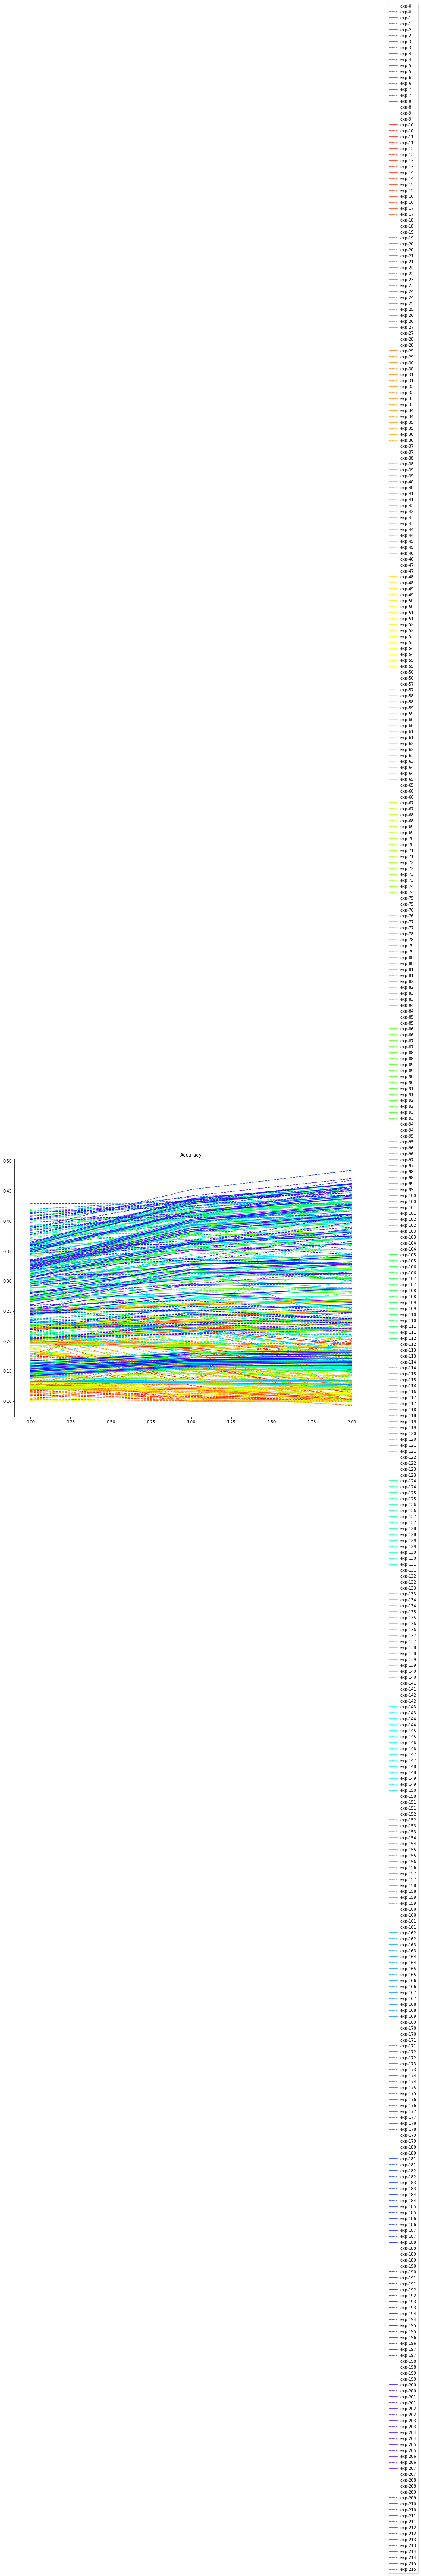

In [32]:
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 250

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.show()

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-accuracy'])),results[cond]['train-accuracy'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-accuracy'])),results[cond]['valid-accuracy'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.show()